In [14]:

import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("Market.xlsx", sheet_name="Market")
print(df.columns)

imputer = SimpleImputer(strategy='mean')
df[['Income']] = imputer.fit_transform(df[['Income']])

print(df['Income'].isnull().sum())
df.to_excel("Market_filled.xlsx", index=False)


variables = ['age', 'spent', 'family_size', 'customer_for']

stats = {
    'Variable': [],
    'Moyenne': [],
    'Médiane': [],
    'Minimum': [],
    'Maximum': []
}
for var in variables:
    stats['Variable'].append(var)
    stats['Moyenne'].append(round(df[var].mean(), 2))
    stats['Médiane'].append(round(df[var].median(), 2))
    stats['Minimum'].append(round(df[var].min(), 2))
    stats['Maximum'].append(round(df[var].max(), 2))

summary_df = pd.DataFrame(stats)

print(summary_df)
summary_df.to_excel("Tableau_Analyse_Descriptive.xlsx", index=False)

#Age
plt.figure(figsize=(10,6))
df['age'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution de l'âge des clients")
plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.show()

#Revenu
plt.figure(figsize=(10,6))
sns.histplot(df['Income'], bins=30, kde=True, color='lightgreen')
plt.title("Distribution du revenu des clients")
plt.xlabel("Revenu")
plt.ylabel("Nombre de clients")
plt.show()

#Dépenses (spent)
plt.figure(figsize=(10,6))
sns.histplot(df['spent'], bins=30, kde=True, color='coral')
plt.title("Distribution du total dépensé sur 2 ans")
plt.xlabel("Montant dépensé (€)")
plt.ylabel("Nombre de clients")
plt.show()

#Corrélations
plt.figure(figsize=(10,8))
corr = df[['Income', 'spent', 'age', 'customer_for', 'family_size']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

#Revenu vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='spent', data=df, color='orange')
plt.title("Relation entre le revenu et le total dépensé")
plt.xlabel("Revenu (€)")
plt.ylabel("Dépenses (€)")
plt.show()


#Âge vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='spent', data=df, color='purple')
plt.title("Relation entre l'âge et les dépenses")
plt.xlabel("Âge")
plt.ylabel("Montant dépensé (€)")
plt.show()





Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'age', 'spent', 'children', 'family_size', 'living_with', 'is_parent',
       'education2', 'customer_for'],
      dtype='object')
0


PermissionError: [Errno 13] Permission denied: 'Market_filled.xlsx'

FONCTIONS EDA et Matrice de Corrélation

In [ ]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Fonctions utilitaires ---
def detect_sep(path: Path) -> str:
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        lines = [f.readline() for _ in range(5)]
    candidates = [",", ";", "\t", "|"]
    best, best_count = ",", -1
    for sep in candidates:
        c = sum(line.count(sep) for line in lines if line)
        if c > best_count:
            best_count, best = c, sep
    return best

def ensure_dir(d: Path) -> Path:
    d.mkdir(parents=True, exist_ok=True)
    return d

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def save_table(df: pd.DataFrame, outdir: Path, name: str):
    p = outdir / f"{name}.csv"
    df.to_csv(p, index=False)
    print(f"[CSV] {p}")
    return p

def save_fig(outdir: Path, name: str):
    p = outdir / f"{name}.png"
    plt.tight_layout()
    plt.savefig(p, dpi=140)
    print(f"[PNG] {p}")
def simplify_marital_status(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    return "couple" if x in {"married","together","union","in relationship"} else "célibataire"

def simplify_education(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    if x in {"master","phd","postgraduate"}: return "postgrad"
    if x in {"graduation","graduate","college","bachelor"}: return "grad"
    return "undergrad"

def add_missing_features(df: pd.DataFrame) -> pd.DataFrame:
    if "Dt_Customer" in df.columns:
        df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce", dayfirst=True)
    if "age" not in df.columns and "Year_Birth" in df.columns:
        df["age"] = 2025 - to_num(df["Year_Birth"])
    if "spent" not in df.columns:
        mnt_cols = [c for c in df.columns if c.lower().startswith("mnt")]
        if mnt_cols:
            df["spent"] = df[mnt_cols].apply(to_num).sum(axis=1)
    if "living_with" not in df.columns and "Marital_Status" in df.columns:
        df["living_with"] = df["Marital_Status"].apply(simplify_marital_status)
    if "education2" not in df.columns and "Education" in df.columns:
        df["education2"] = df["Education"].apply(simplify_education)
    if "is_parent" not in df.columns and {"Kidhome","Teenhome"}.issubset(df.columns):
        df["children"] = to_num(df["Kidhome"]).fillna(0) + to_num(df["Teenhome"]).fillna(0)
        df["is_parent"] = (df["children"] > 0).astype(int)
    if "Response" in df.columns and not pd.api.types.is_numeric_dtype(df["Response"]):
        df["Response"] = to_num(df["Response"])
    return df

# --- Matrice de corrélation ---
def show_corr_heatmap(df_num, outdir: Path, fname: str):
    if df_num.shape[1] < 2:
        print("[INFO] Pas assez de colonnes numériques pour la corrélation.")
        return None
    corr = df_num.corr()
    plt.figure(figsize=(12, 8))
    plt.imshow(corr.values, aspect='auto', cmap="coolwarm")
    plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
    plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns)
    plt.title("Matrice de corrélation (numérique)")
    plt.colorbar()
    plt.show()
    return corr


LANCEMENT DE L’ANALYSE EDA

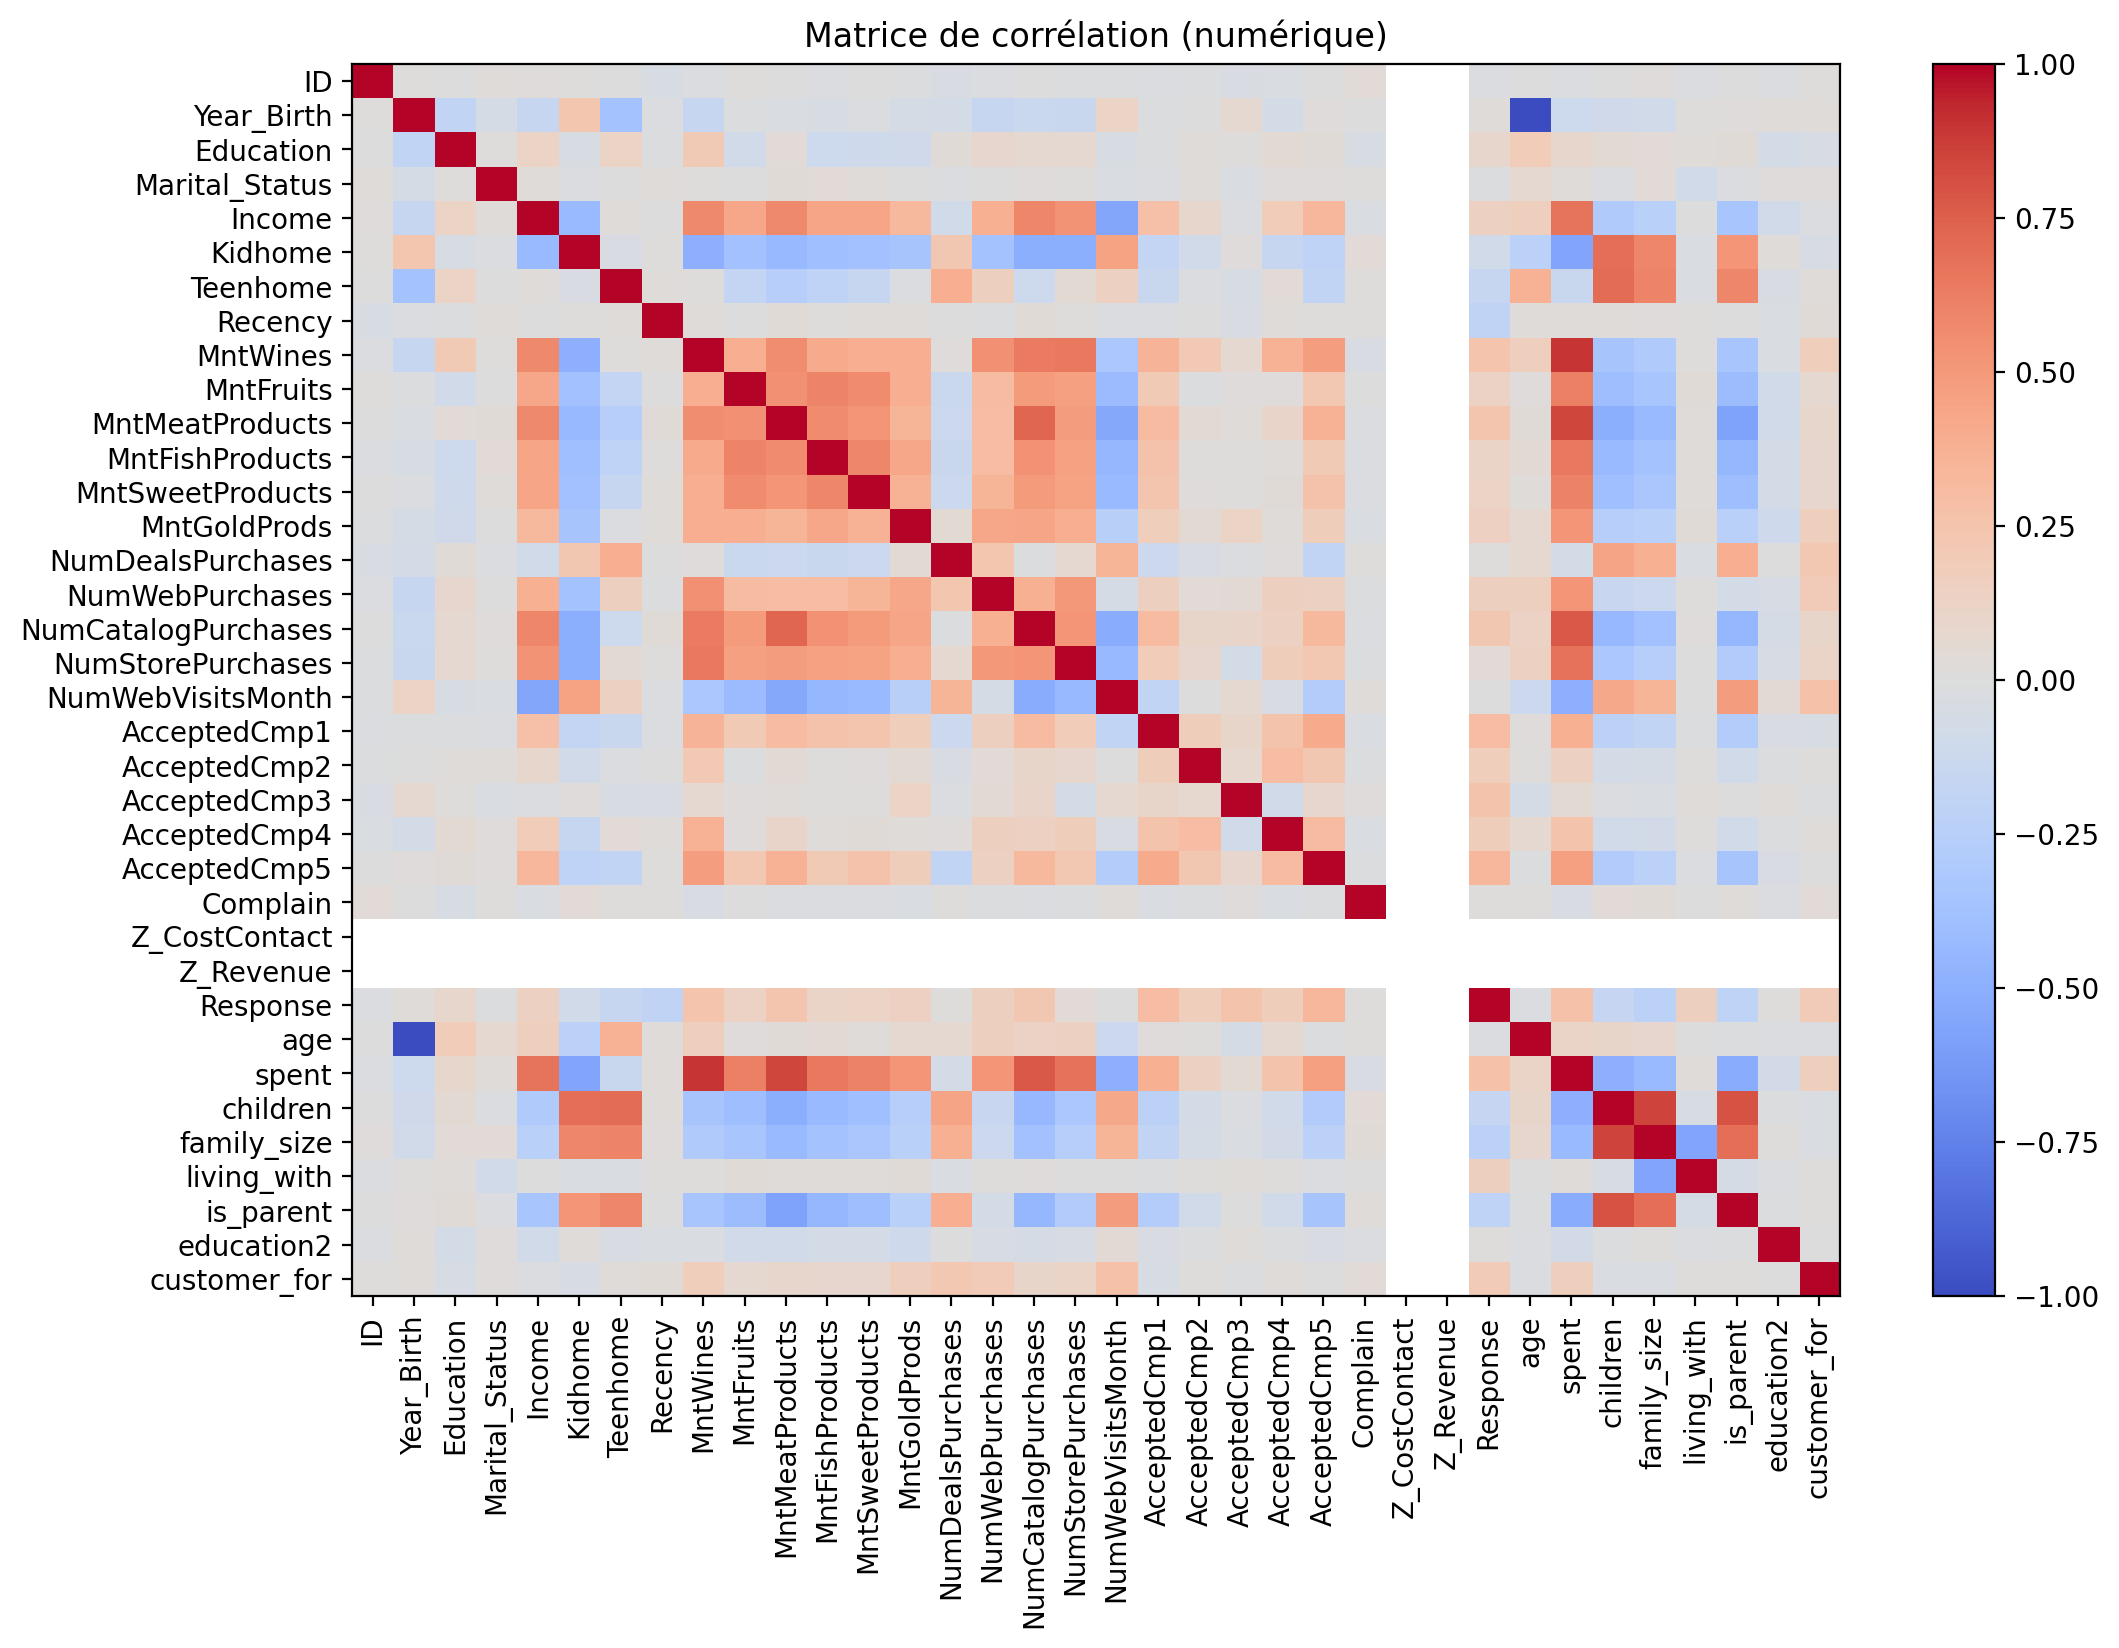

In [ ]:
file_path = Path("Market_filled.xlsx")
df = add_missing_features(df)
outdir = ensure_dir(Path("eda_output"))

corr = show_corr_heatmap(df.select_dtypes(include=np.number), outdir, "heatmap_corr")


Encodage et standardscalerr

In [6]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_excel("Market_filled.xlsx")
non_numeric_cols = df.select_dtypes(include=['object']).columns
print("🔍 Colonnes non numériques détectées :", list(non_numeric_cols))
 
le = LabelEncoder()
for col in non_numeric_cols:
    df[col] = le.fit_transform(df[col].astype(str))
 
print("✅ Colonnes encodées :", list(non_numeric_cols))
cols_to_drop = [
    'ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
    'AcceptedCmp4', 'AcceptedCmp5', 'Response',
    'Z_CostContact', 'Z_Revenue', 'Dt_Customer'  
]
df_scaled = df.drop(columns=cols_to_drop, errors='ignore')
print("Colonnes conservées pour le scaling :", list(df_scaled.columns))
print("Types de données :", df_scaled.dtypes.unique())
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(scaled_data, columns=df_scaled.columns)
df_scaled.to_excel("Camp_Market_encoded_scaled.xlsx", index=False)
 
print("✅ Encodage + Scaling terminés et sauvegardés dans : Camp_Market_encoded_scaled.xlsx")
 
 

🔍 Colonnes non numériques détectées : ['Education', 'Marital_Status', 'living_with', 'education2']
✅ Colonnes encodées : ['Education', 'Marital_Status', 'living_with', 'education2']
Colonnes conservées pour le scaling : ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'age', 'spent', 'children', 'family_size', 'living_with', 'is_parent', 'education2', 'customer_for']
Types de données : [dtype('int64') dtype('float64')]
✅ Encodage + Scaling terminés et sauvegardés dans : Camp_Market_encoded_scaled.xlsx


PCA & K-MEANS

📘 Feuilles disponibles : ['Sheet1']
✅ Données chargées (2237 lignes, 37 colonnes)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_Revenue,Response,age,spent,children,family_size,living_with,is_parent,education2,customer_for
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,11,1,68,1617,0,1,Single,0,Graduate,663
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,11,0,71,27,2,3,Single,1,Graduate,113
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,11,0,60,776,0,2,Partner,0,Graduate,312
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,11,0,41,53,1,3,Partner,1,Graduate,139
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,11,0,44,422,1,3,Partner,1,Postgraduate,161


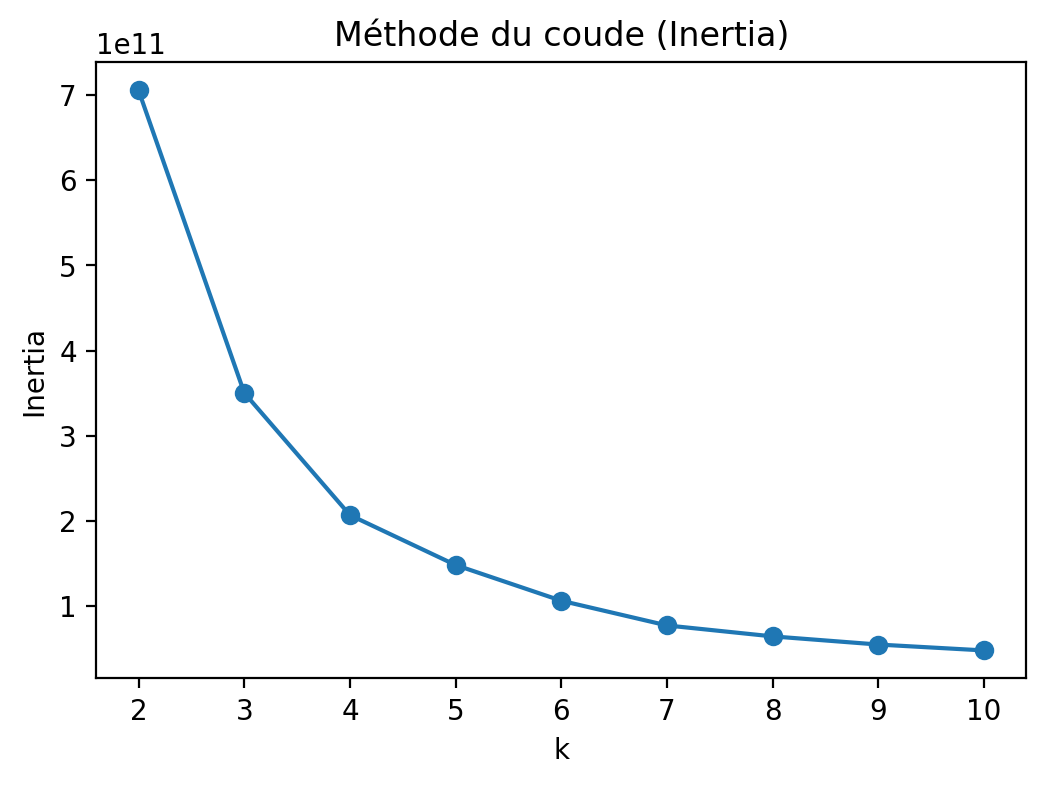

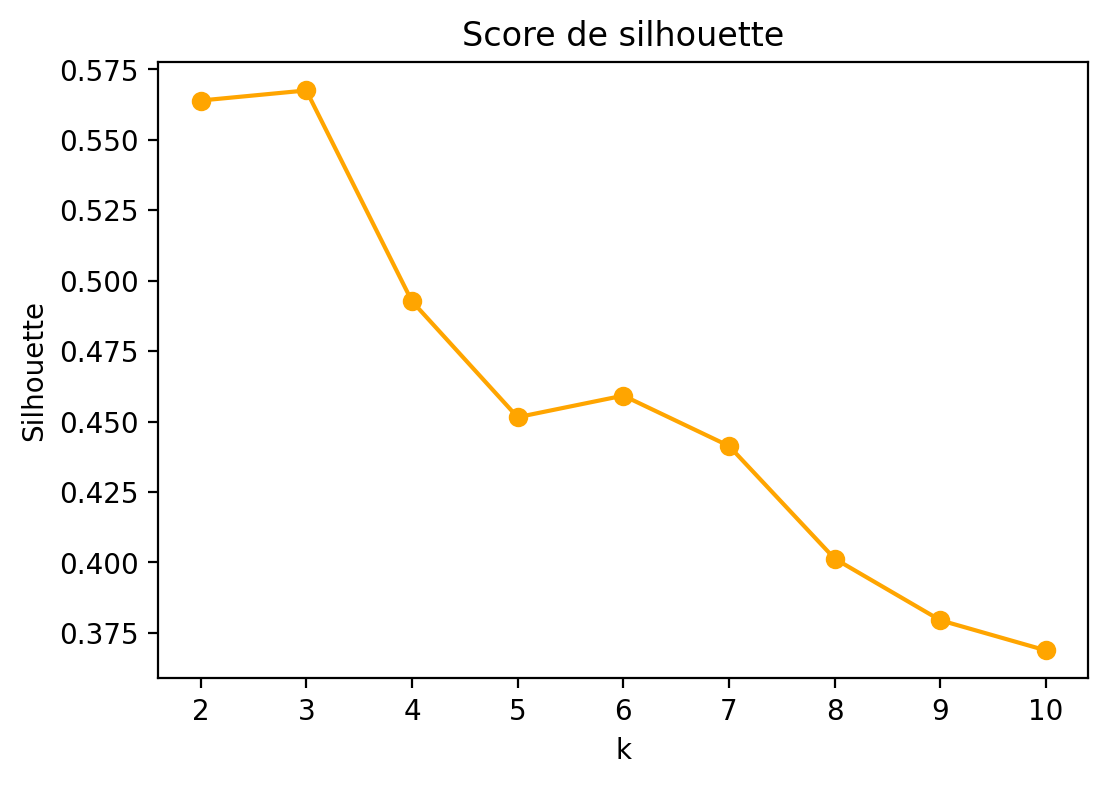

✅ Meilleur k choisi (silhouette max) = 3


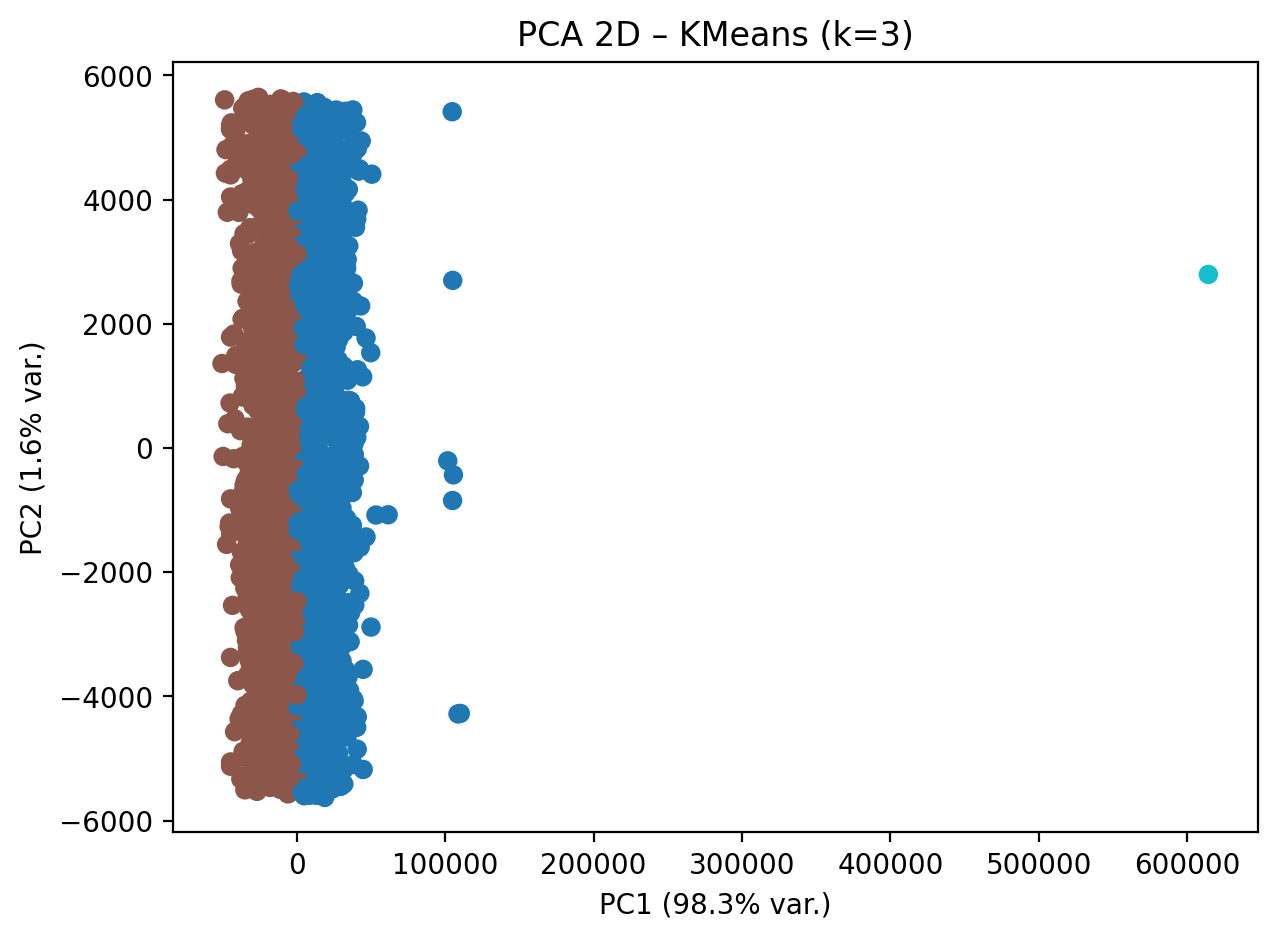

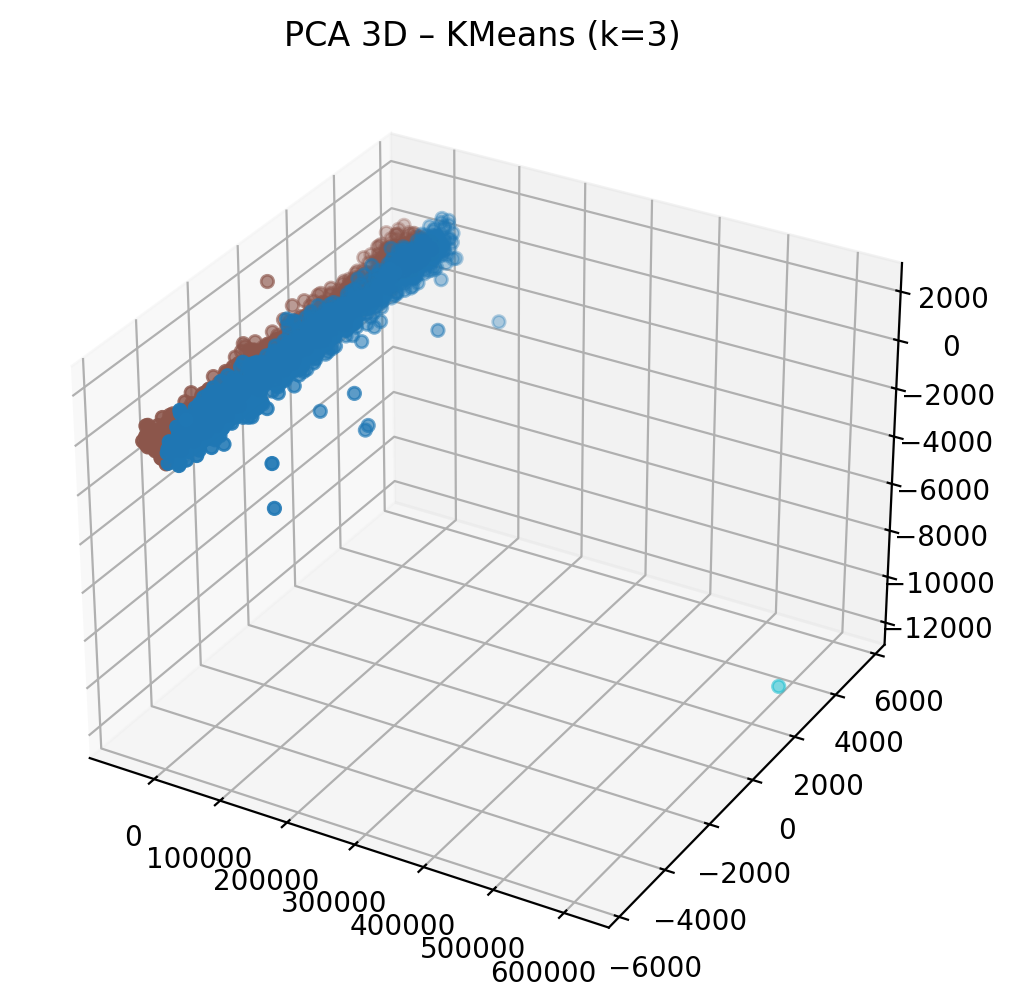


📊 Moyennes numériques par cluster :


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Z_CostContact,Z_Revenue,Response,age,spent,children,family_size,is_parent,customer_for
cluster,,,,,,,,,,,,,,,,,,,,,
0,5626.667290,1966.714953,70411.804673,0.153271,0.538318,48.967290,544.499065,46.770093,305.921495,65.743925,...,0.006542,3.0,11.0,0.190654,58.285047,1076.689720,0.691589,2.347664,0.557009,354.281308
1,5554.450257,1970.901372,35030.819861,0.710978,0.477702,49.253002,83.546312,7.469125,39.484563,11.650943,...,0.011149,3.0,11.0,0.111492,54.098628,174.037736,1.188679,2.823328,0.860206,353.307033
2,9432.000000,1977.000000,666666.000000,1.000000,0.000000,23.000000,9.000000,14.000000,18.000000,8.000000,...,0.000000,3.0,11.0,0.000000,48.000000,62.000000,1.000000,3.000000,1.000000,392.000000



📈 Taux de réponse par cluster :


cluster
0    0.190654
1    0.111492
2    0.000000
Name: Response, dtype: float64

In [13]:
# ============================================
# 🔹 PCA & K-MEANS - VERSION NOTEBOOK AUTOMATIQUE
# ============================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import os

# ---------- UTILS ----------
def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def to_num(s): 
    return pd.to_numeric(s, errors="coerce")

# ---------- PREPARE FEATURES ----------
def ensure_engineered(df: pd.DataFrame) -> pd.DataFrame:
    """Ajoute les variables calculées : âge, dépenses, enfants, etc."""
    if "Dt_Customer" in df.columns:
        df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce", dayfirst=True)
    if "age" not in df.columns and "Year_Birth" in df.columns:
        df["age"] = 2025 - to_num(df["Year_Birth"])
    if "spent" not in df.columns:
        mnt_cols = [c for c in df.columns if c.lower().startswith("mnt")]
        if mnt_cols:
            df["spent"] = df[mnt_cols].apply(to_num).sum(axis=1)
    if "is_parent" not in df.columns and {"Kidhome","Teenhome"}.issubset(df.columns):
        df["children"] = to_num(df["Kidhome"]).fillna(0) + to_num(df["Teenhome"]).fillna(0)
        df["is_parent"] = (df["children"] > 0).astype(int)
    return df

# ---------- CHOIX DU K ----------
def choose_k(X, k_min=2, k_max=10):
    """Teste plusieurs valeurs de k et trace les courbes Inertia et Silhouette."""
    inertias, silhouettes = [], []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        try:
            silhouettes.append(silhouette_score(X, labels))
        except:
            silhouettes.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(range(k_min, k_max+1), inertias, marker='o')
    plt.title("Méthode du coude (Inertia)")
    plt.xlabel("k"); plt.ylabel("Inertia")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(range(k_min, k_max+1), silhouettes, marker='o', color='orange')
    plt.title("Score de silhouette")
    plt.xlabel("k"); plt.ylabel("Silhouette")
    plt.show()

    best_k = np.nanargmax(silhouettes) + k_min
    print(f"✅ Meilleur k choisi (silhouette max) = {best_k}")
    return best_k

# ---------- PCA & KMEANS ----------
def run_kmeans_pca(df, k):
    """Applique KMeans et affiche la PCA en 2D et 3D."""
    X = df.select_dtypes(include=np.number).dropna()
    
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(X)
    df["cluster"] = labels

    # PCA 2D
    pca2 = PCA(n_components=2, random_state=42)
    X2 = pca2.fit_transform(X)
    plt.figure(figsize=(7,5))
    plt.scatter(X2[:,0], X2[:,1], c=labels, cmap='tab10')
    plt.title(f"PCA 2D – KMeans (k={k})")
    plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var.)")
    plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var.)")
    plt.show()

    # PCA 3D
    from mpl_toolkits.mplot3d import Axes3D
    pca3 = PCA(n_components=3, random_state=42)
    X3 = pca3.fit_transform(X)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X3[:,0], X3[:,1], X3[:,2], c=labels, cmap='tab10')
    ax.set_title(f"PCA 3D – KMeans (k={k})")
    plt.show()

    return df, labels

# ---------- PROFILAGE DES CLUSTERS ----------
def cluster_profile(df):
    """Affiche les moyennes numériques et le taux de réponse par cluster."""
    print("\n📊 Moyennes numériques par cluster :")
    display(df.groupby("cluster").mean(numeric_only=True))
    if "Response" in df.columns:
        print("\n📈 Taux de réponse par cluster :")
        display(df.groupby("cluster")["Response"].mean())

# ---------- LECTURE AUTOMATIQUE DU FICHIER ----------
file_path = Path("Market_filled.xlsx")  # ou .csv, détecté automatiquement

if not file_path.exists():
    file_path = Path("Market_filled.csv")

# Détection du type de fichier
if file_path.suffix == ".csv":
    df = pd.read_csv(file_path)
else:
    xls = pd.ExcelFile(file_path)
    print("📘 Feuilles disponibles :", xls.sheet_names)
    df = pd.read_excel(file_path, sheet_name=xls.sheet_names[0])  # première feuille

# Préparation des données
df = ensure_engineered(df)
print(f"✅ Données chargées ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
display(df.head())

# ---------- EXÉCUTION ----------
# Sélection du k optimal
X = df.select_dtypes(include=np.number).dropna()
best_k = choose_k(X, 2, 10)

# KMeans + PCA
df, labels = run_kmeans_pca(df, best_k)

# Profil clusters
cluster_profile(df)
